In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [8]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10/GTEx_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10/sim_samples/"

num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
real_gtf = pd.read_csv(base_dir_data+"real.gtf",sep="\t",names=gff3cols)
real_gtf["tid_real"] = real_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
splice_gtf = pd.read_csv(base_dir_data+"splicing.gtf",sep="\t",names=gff3cols)
splice_gtf["tid_splicing"] = splice_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
int_gtf = pd.read_csv(base_dir_data+"intronic.gtf",sep="\t",names=gff3cols)
int_gtf["tid_intronic"] = int_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
pol_gtf = pd.read_csv(base_dir_data+"RNApol.gtf",sep="\t",names=gff3cols)
pol_gtf["tid_polymerase"] = pol_gtf["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]

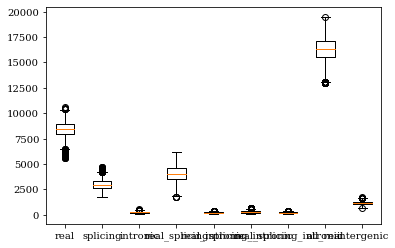

In [9]:
# based on the number of loci per sample
s_loc = pd.read_csv(base_dir_out+"res.num_locs_sample")

for label in s_loc.columns:
    # now we shall remove any outliers from the data
    q25,q50,q75 = s_loc[label].quantile([0.25,0.5,0.75])
    iqr = q75-q25
    thw = q75+1.5*iqr
    tlw = q25-1.5*iqr
    ahw = s_loc[s_loc[label]<=thw][label].max()
    alw = s_loc[s_loc[label]>=tlw][label].min()
    s_loc = s_loc[(s_loc[label]<=ahw)&(s_loc[label]>=alw)].reset_index(drop=True)

fig,ax = plt.subplots()
ax.boxplot(s_loc.T,labels=s_loc.T.index.tolist())
plt.show()

In [ ]:
sloc_df = pd.read_csv(base_dir_out+"res.num_tx_per_sample_loc4")
sloc_df_real = sloc_df[sloc_df["total_polymerase"]==0][["real","splicing","intronic","total_real","total_splicing","total_intronic"]].reset_index(drop=True)
sloc_df_real.to_csv(out_dir+"sloc.df",header=False,index=False)
sloc_df_pol = sloc_df[sloc_df["total_polymerase"]>0][["polymerase","total_polymerase"]].reset_index(drop=True)
sloc_df_pol

In [ ]:
for tissue_num in range(num_tissues):
    print("\n=================\nTissue #"+str(tissue_num)+"\n=================\n")
    realDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.real_t"+str(tissue_num))
    spliceDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.splice_t"+str(tissue_num))
    intDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.int_t"+str(tissue_num))
    polDF = pd.read_csv(out_dir+"stage2_tid_lid_exp.pol_t"+str(tissue_num))
    
    print("starting number of real loci: "+str(len(set(realDF["lid"]))))
    print("starting number of splicing loci: "+str(len(set(spliceDF["lid"]))))
    print("starting number of intronic loci: "+str(len(set(intDF["lid"]))))
    print("starting number of intergenic loci: "+str(len(set(polDF[i]["lid"]))))
    
    for sample_num in range(num_samples):
        print("++++++\n>Sample #"+str(sample_num)+"\n++++++\n")
        # ==================================
        # get numbers
        # ==================================
        realn,splicen,intn,real_splicen,real_intn,splice_intn,real_splice_intn,all_realn,poln = s_loc.sample()[["real",\
                                                                                                                "splicing",\
                                                                                                                "intronic",\
                                                                                                                "real_splicing",\
                                                                                                                "real_intronic",\
                                                                                                                "splicing_intronic",\
                                                                                                                "real_splicing_intronic",\
                                                                                                                "all_real",\
                                                                                                                "intergenic"]].iloc[0].tolist()

        print("selecting "+str(poln)+" intergenic loci")
        
        # ==================================
        # Now to generate sample from tissue
        # for intergenic set
        # ==================================
        
        # now let's split this into samples the old way
        polDF_g = polDF.groupby("lid").agg({"tid_polymerase":{"tids_pol":lambda x:list(x),
                                                                         "count_pol":"count"},
                                                              "polymerase_mean_tpm":lambda x:list(x),
                                                              "polymerase_sd_tpm":lambda x:list(x)}).reset_index()
        polDF_g.columns = ["lid","tids_pol","count_pol","polymerase_mean_tpm","polymerase_sd_tpm"]

        # now for each of these we need to select how many we want to have in a sample based on a distribution
        num_dropped = 0
        def cond_merge_pol(g,df):
            nt = int(g["count_pol"].iloc[0])
            sub = df[df["total_polymerase"]==nt]
            if not len(sub)>=len(g):
                global num_dropped
                num_dropped+=1
                return
            sub = sub.sample(n=len(g),replace=False).reset_index(drop=True)
            g2 = pd.concat([g.reset_index(drop=True),sub[["polymerase"]]],axis=1)
            assert len(g2)==len(g),"uneven length"
            return g2

        polDF_g_sample = polDF_g.groupby('count_pol').apply(cond_merge_pol,sloc_df_pol).reset_index(drop=True)
        print("number of intergenic tissue loci: "+str(len(polDF_g_sample)))
        print("number of intergenic loci without a match: "+str(num_dropped))

        ttx_pol = list()
        tpm_pol = list()

        def get_tx_tpm_pol(row):
            global ttx_pol
            global tpm_pol

            if row["polymerase"]==row["count_pol"]:
                ttx_pol.extend(row["tids_pol"])
                for i in range(row["polymerase"]):
                    new_tpm = np.random.normal(row["polymerase_mean_tpm"][i],row["polymerase_sd_tpm"][i],1)[0]
                    tpm_pol.append(max(0.1,new_tpm))
                return

            tids = np.array(row["tids_pol"])
            ntx_total = len(tids)
            tid_ids = list(range(ntx_total)) # only the indices will be shuffled, allowing to maintain consistent sampling of both txs and corresponding tpms
            random.shuffle(tid_ids)

            for i in tid_ids[:row["polymerase"]]:
                ttx_pol.append(tids[i])
                new_tpm = np.random.normal(row["polymerase_mean_tpm"][i],row["polymerase_sd_tpm"][i],1)[0]
                tpm_pol.append(max(0.1,new_tpm))

        polDF_g_sample.apply(lambda row: get_tx_tpm_pol(row),axis=1)
        print("number of intergenic transcripts before subsetting: "+str(len(ttx_pol)))

        # now we can save the results
        res_pol = pd.concat([pd.DataFrame(ttx_pol,columns=["tid_polymerase"]),pd.DataFrame(tpm_pol,columns=["tpm"])],axis=1)
        polDF_f = polDF[["lid","tid_polymerase"]].merge(res_pol,on="tid_polymerase",how="inner")
        noise_locIDs_tmp = list(set(polDF_f["lid"]))
        random.shuffle(noise_locIDs_tmp)
        noise_locIDs_tmp = noise_locIDs_tmp[:poln]
        polDF_f = polDF_f[polDF_f["lid"].isin(noise_locIDs_tmp)].reset_index(drop=True)
        
        polDF_f = pol_gtf.merge(polDF_f[["tid_polymerase","tpm"]],on="tid_polymerase",how="inner")
        polDF_f["attributes"] = polDF_f["attributes"].str.rstrip(";")+\
            ";sim_tpm="+polDF_f["tpm"].astype(str)
        polDF_f[gff3cols].to_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        polDF_f[polDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)
        polDF_f.head()
        
        
        # ==================================
        # Now to do the same for real loci
        # ==================================
        
        # now let's split this into samples the old way
        realDF_g = realDF.groupby("lid").agg({"tid_real":{"tids_real":lambda x:list(x),
                                                                "count_real":"count"},
                                              "real_mean_tpm":lambda x:list(x),
                                              "real_sd_tpm":lambda x:list(x)}).reset_index()
        realDF_g.columns = ["lid","tids_real","count_real","real_mean_tpm","real_sd_tpm"]

        # now let's split this into samples the old way
        spliceDF_g = spliceDF.groupby("lid").agg({"tid_splicing":{"tids_splicing":lambda x:list(x),
                                                                "count_splicing":"count"},
                                              "splicing_mean_tpm":lambda x:list(x),
                                              "splicing_sd_tpm":lambda x:list(x)}).reset_index()
        spliceDF_g.columns = ["lid","tids_splicing","count_splicing","splicing_mean_tpm","splicing_sd_tpm"]

        # now let's split this into samples the old way
        intDF_g = intDF.groupby("lid").agg({"tid_intronic":{"tids_intronic":lambda x:list(x),
                                                                "count_intronic":"count"},
                                              "intronic_mean_tpm":lambda x:list(x),
                                              "intronic_sd_tpm":lambda x:list(x)}).reset_index()
        intDF_g.columns = ["lid","tids_intronic","count_intronic","intronic_mean_tpm","intronic_sd_tpm"]

        all_g_lid = realDF_g.merge(spliceDF_g,how="outer",on="lid")
        all_g_lid = all_g_lid.merge(intDF_g,how="outer",on="lid")
        all_g_lid["count_real"] = all_g_lid["count_real"].fillna(0)
        all_g_lid["count_splicing"] = all_g_lid["count_splicing"].fillna(0)
        all_g_lid["count_intronic"] = all_g_lid["count_intronic"].fillna(0)

        all_g_lid["count_real"]=all_g_lid["count_real"].astype(int)
        all_g_lid["count_splicing"]=all_g_lid["count_splicing"].astype(int)
        all_g_lid["count_intronic"]=all_g_lid["count_intronic"].astype(int)

        # todo: compare to running the get_txs - are the results roughly the same?
        agl = all_g_lid.copy(deep=True)
        agl["tids_real"]=np.where(agl["count_real"]>0,agl["tids_real"].str.join(";"),"")
        agl["tids_splicing"]=np.where(agl["count_splicing"]>0,agl["tids_splicing"].str.join(";"),"")
        agl["tids_intronic"]=np.where(agl["count_intronic"]>0,agl["tids_intronic"].str.join(";"),"")

        def get_str(row):
            if len(row)>0:
                return ";".join([str(x) for x in row])
            else:
                return ""

        agl["real_mean_tpm"]=np.where(agl["count_real"]>0,agl["real_mean_tpm"],"")
        agl["real_mean_tpm"]=agl["real_mean_tpm"].apply(lambda row: get_str(row))
        agl["splicing_mean_tpm"]=np.where(agl["count_splicing"]>0,agl["splicing_mean_tpm"],"")
        agl["splicing_mean_tpm"]=agl["splicing_mean_tpm"].apply(lambda row: get_str(row))
        agl["intronic_mean_tpm"]=np.where(agl["count_intronic"]>0,agl["intronic_mean_tpm"],"")
        agl["intronic_mean_tpm"]=agl["intronic_mean_tpm"].apply(lambda row: get_str(row))

        agl["real_sd_tpm"]=np.where(agl["count_real"]>0,agl["real_sd_tpm"],"")
        agl["real_sd_tpm"]=agl["real_sd_tpm"].apply(lambda row: get_str(row))
        agl["splicing_sd_tpm"]=np.where(agl["count_splicing"]>0,agl["splicing_sd_tpm"],"")
        agl["splicing_sd_tpm"]=agl["splicing_sd_tpm"].apply(lambda row: get_str(row))
        agl["intronic_sd_tpm"]=np.where(agl["count_intronic"]>0,agl["intronic_sd_tpm"],"")
        agl["intronic_sd_tpm"]=agl["intronic_sd_tpm"].apply(lambda row: get_str(row))

        agl[["lid",\
                   "count_real",\
                   "tids_real",\
                   "real_mean_tpm",\
                   "real_sd_tpm",\
                   "count_splicing",\
                   "tids_splicing",\
                   "splicing_mean_tpm",\
                   "splicing_sd_tpm",\
                   "count_intronic",\
                   "tids_intronic",\
                   "intronic_mean_tpm",\
                   "intronic_sd_tpm"]].to_csv(out_dir+"all_g_lid.df_t"+str(tissue_num)+"_s"+str(sample_num),header=False,index=False)

        gt_cmd = ["/ccb/salz8-1/avaraby/tx_noise/get_txs/get_txs "+\
                  out_dir+"sloc.df "+\
                  out_dir+"all_g_lid.df_t"+str(tissue_num)+"_s"+str(sample_num)+" "+\
                  out_dir+"real.sub_t"+str(tissue_num)+"_s"+str(sample_num)+" "+\
                  out_dir+"splicing.sub_t"+str(tissue_num)+"_s"+str(sample_num)+" "+\
                  out_dir+"intronic.sub_t"+str(tissue_num)+"_s"+str(sample_num)]
        subprocess.call(gt_cmd,shell=True)
        
        real_sub = pd.read_csv(out_dir+"real.sub_t"+str(tissue_num)+"_s"+str(sample_num))
        splicing_sub = pd.read_csv(out_dir+"splicing.sub_t"+str(tissue_num)+"_s"+str(sample_num))
        intronic_sub = pd.read_csv(out_dir+"intronic.sub_t"+str(tissue_num)+"_s"+str(sample_num))
        print("number of real transcripts: "+str(len(set(real_sub["tid"]))))
        print("number of solicing transcripts: "+str(len(set(splicing_sub["tid"]))))
        print("number of intronic transcripts: "+str(len(set(intronic_sub["tid"]))))
        print("number of real genes: "+str(len(set(real_sub["lid"]))))
        print("number of solicing genes: "+str(len(set(splicing_sub["lid"]))))
        print("number of intronic genes: "+str(len(set(intronic_sub["lid"]))))

        # get new TPM value
        real_sub["tpm"] = real_sub.apply(lambda row: max(0.1,np.random.normal(row["tpm_mean"],row["tpm_sd"],1)[0]),axis=1)
        real_sub[["tpm"]].to_csv(out_dir+"/real.sample"+str(i)+".exp",index=False,header=False)

        splicing_sub["tpm"] = splicing_sub.apply(lambda row: max(0.1,np.random.normal(row["tpm_mean"],row["tpm_sd"],1)[0]),axis=1)
        splicing_sub[["tpm"]].to_csv(out_dir+"/splicing.sample"+str(i)+".exp",index=False,header=False)

        intronic_sub["tpm"] = intronic_sub.apply(lambda row: max(0.1,np.random.normal(row["tpm_mean"],row["tpm_sd"],1)[0]),axis=1)
        intronic_sub[["tpm"]].to_csv(out_dir+"/intronic.sample"+str(i)+".exp",index=False,header=False)

        real_sub = real_sub[real_sub["tpm"]>0].reset_index(drop=True)
        splicing_sub = splicing_sub[splicing_sub["tpm"]>0].reset_index(drop=True)
        intronic_sub = intronic_sub[intronic_sub["tpm"]>0].reset_index(drop=True)

        ttx_real = list(real_sub["tid"])
        tpm_real = list(real_sub["tpm"])

        ttx_splice = list(splicing_sub["tid"])
        tpm_splice = list(splicing_sub["tpm"])

        ttx_int = list(intronic_sub["tid"])
        tpm_int = list(intronic_sub["tpm"])
        
        print("targeting "+str(realn)+" real only loci")
        print("targeting "+str(splicen)+" splicing only loci")
        print("targeting "+str(intn)+" intronic only loci")
        print("targeting "+str(real_splicen)+" real and splicing loci")
        print("targeting "+str(real_intn)+" real and intronic loci")
        print("targeting "+str(splice_intn)+" splicing and intronic loci")
        print("targeting "+str(real_splice_intn)+" real and splicing and intronic loci")

        real_sample_locs = set(real_sub["lid"])
        splicing_sample_locs = set(splicing_sub["lid"])
        intronic_sample_locs = set(intronic_sub["lid"])

        real_only_sample_locs = list(real_sample_locs-(splicing_sample_locs.union(intronic_sample_locs)))
        splicing_only_sample_locs = list(splicing_sample_locs-(real_sample_locs.union(intronic_sample_locs)))
        intronic_only_sample_locs = list(intronic_sample_locs-(real_sample_locs.union(splicing_sample_locs)))

        real_splicing_sample_locs = list(real_sample_locs.intersection(splicing_sample_locs)-intronic_sample_locs)
        real_intronic_sample_locs = list(real_sample_locs.intersection(intronic_sample_locs)-splicing_sample_locs)
        splicing_intronic_sample_locs = list(splicing_sample_locs.intersection(intronic_sample_locs)-real_sample_locs)

        real_splicing_intronic_sample_locs = list(real_sample_locs.intersection(splicing_sample_locs.intersection(intronic_sample_locs)))

        print("available real only loci: "+str(len(real_only_sample_locs)))
        print("available splicing only loci: "+str(len(splicing_only_sample_locs)))
        print("available intronic only loci: "+str(len(intronic_only_sample_locs)))
        print("available real and splicing loci: "+str(len(real_splicing_sample_locs)))
        print("available real and intronic loci: "+str(len(real_intronic_sample_locs)))
        print("available splicing and intronic loci: "+str(len(splicing_intronic_sample_locs)))
        print("available real and splicing and intronic loci: "+str(len(real_splicing_intronic_sample_locs)))

        random.shuffle(real_only_sample_locs)
        min_realn = min(len(real_only_sample_locs),realn)
        real_only_sample_locs = real_only_sample_locs[:min_realn]
        random.shuffle(splicing_only_sample_locs)
        min_splicen = min(len(splicing_only_sample_locs),splicen)
        splicing_only_sample_locs = splicing_only_sample_locs[:min_splicen]
        random.shuffle(intronic_only_sample_locs)
        min_intn = min(len(intronic_only_sample_locs),intn)
        intronic_only_sample_locs = intronic_only_sample_locs[:min_intn]

        random.shuffle(real_splicing_sample_locs)
        min_real_splicen = min(len(real_splicing_sample_locs),real_splicen)
        real_splicing_sample_locs = real_splicing_sample_locs[:min_real_splicen]
        random.shuffle(real_intronic_sample_locs)
        min_real_intn = min(len(real_intronic_sample_locs),real_intn)
        real_intronic_sample_locs = real_intronic_sample_locs[:min_real_intn]
        random.shuffle(splicing_intronic_sample_locs)
        min_splice_intn = min(len(splicing_intronic_sample_locs),splice_intn)
        splicing_intronic_sample_locs = splicing_intronic_sample_locs[:min_splice_intn]

        random.shuffle(real_splicing_intronic_sample_locs)
        min_real_splice_intn = min(len(real_splicing_intronic_sample_locs),real_splice_intn)
        real_splicing_intronic_sample_locs = real_splicing_intronic_sample_locs[:min_real_splice_intn]

        print("selecting real only loci: "+str(len(real_only_sample_locs)))
        print("selecting splicing only loci: "+str(len(splicing_only_sample_locs)))
        print("selecting intronic only loci: "+str(len(intronic_only_sample_locs)))
        print("selecting real and splicing loci: "+str(len(real_splicing_sample_locs)))
        print("selecting real and intronic loci: "+str(len(real_intronic_sample_locs)))
        print("selecting splicing and intronic loci: "+str(len(splicing_intronic_sample_locs)))
        print("selecting real and splicing and intronic loci: "+str(len(real_splicing_intronic_sample_locs)))
        
        real_only_sample_df = real_sub[real_sub["lid"].isin(real_only_sample_locs)].reset_index(drop=True)
        splicing_only_sample_df = splicing_sub[splicing_sub["lid"].isin(splicing_only_sample_locs)].reset_index(drop=True)
        intronic_only_sample_df = intronic_sub[intronic_sub["lid"].isin(intronic_only_sample_locs)].reset_index(drop=True)

        real_splicing_only_sample_df = real_sub[real_sub["lid"].isin(real_splicing_sample_locs)].reset_index(drop=True)
        splicing_real_only_sample_df = splicing_sub[splicing_sub["lid"].isin(real_splicing_sample_locs)].reset_index(drop=True)

        real_intronic_only_sample_df = real_sub[real_sub["lid"].isin(real_intronic_sample_locs)].reset_index(drop=True)
        intronic_real_only_sample_df = intronic_sub[intronic_sub["lid"].isin(real_intronic_sample_locs)].reset_index(drop=True)

        splicing_intronic_only_sample_df = splicing_sub[splicing_sub["lid"].isin(splicing_intronic_sample_locs)].reset_index(drop=True)
        intronic_splicing_only_sample_df = intronic_sub[intronic_sub["lid"].isin(splicing_intronic_sample_locs)].reset_index(drop=True)

        real_splicing_intronic_only_sample_df = real_sub[real_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)
        splicing_real_intronic_only_sample_df = splicing_sub[splicing_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)
        intronic_real_splicing_only_sample_df = intronic_sub[intronic_sub["lid"].isin(real_splicing_intronic_sample_locs)].reset_index(drop=True)

        real_sub2 = pd.concat([real_only_sample_df,\
                               real_splicing_only_sample_df,\
                               real_intronic_only_sample_df,\
                               real_splicing_intronic_only_sample_df],axis=0).reset_index(drop=True)
        splicing_sub2 = pd.concat([splicing_only_sample_df,\
                                   splicing_real_only_sample_df,\
                                   splicing_intronic_only_sample_df,\
                                   splicing_real_intronic_only_sample_df],axis=0).reset_index(drop=True)
        intronic_sub2 = pd.concat([intronic_only_sample_df,\
                                   intronic_real_only_sample_df,\
                                   intronic_splicing_only_sample_df,\
                                   intronic_real_splicing_only_sample_df],axis=0).reset_index(drop=True)

        print("final number of real transcripts: "+str(len(set(real_sub2["tid"]))))
        print("final number of splicing transcripts: "+str(len(set(splicing_sub2["tid"]))))
        print("final number of intronic transcripts: "+str(len(set(intronic_sub2["tid"]))))
        print("final number of real loci: "+str(len(set(real_sub2["lid"]))))
        print("final number of splicing loci: "+str(len(set(splicing_sub2["lid"]))))
        print("final number of intronic loci: "+str(len(set(intronic_sub2["lid"]))))

        ttx_real = list(real_sub2["tid"])
        tpm_real = list(real_sub2["tpm"])

        ttx_splice = list(splicing_sub2["tid"])
        tpm_splice = list(splicing_sub2["tpm"])

        ttx_int = list(intronic_sub2["tid"])
        tpm_int = list(intronic_sub2["tpm"])
        
        # now we can save the results
        res_real = pd.concat([pd.DataFrame(ttx_real,columns=["tid_real"]),pd.DataFrame(tpm_real,columns=["tpm"])],axis=1)
        realDF_f = realDF[["lid","tid_real"]].merge(res_real,on="tid_real",how="inner")
        realDF_f = real_gtf.merge(realDF_f[["tid_real","tpm"]],on="tid_real",how="inner")
        realDF_f["attributes"] = realDF_f["attributes"].str.rstrip(";")+\
                                    ";sim_tpm="+realDF_f["tpm"].astype(str)
        realDF_f[gff3cols].to_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        realDF_f[realDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)
        realDF_f.head()

        # now we can save the results
        res_splicing = pd.concat([pd.DataFrame(ttx_splice,columns=["tid_splicing"]),pd.DataFrame(tpm_splice,columns=["tpm"])],axis=1)
        splicingDF_f = spliceDF[["lid","tid_splicing"]].merge(res_splicing,on="tid_splicing",how="inner")
        splicingDF_f = splice_gtf.merge(splicingDF_f[["tid_splicing","tpm"]],on="tid_splicing",how="inner")
        splicingDF_f["attributes"] = splicingDF_f["attributes"].str.rstrip(";")+\
            ";sim_tpm="+splicingDF_f["tpm"].astype(str)
        splicingDF_f[gff3cols].to_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        splicingDF_f[splicingDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)
        splicingDF_f.head()

        # now we can save the results
        res_intronic = pd.concat([pd.DataFrame(ttx_int,columns=["tid_intronic"]),pd.DataFrame(tpm_int,columns=["tpm"])],axis=1)
        intronicDF_f = intDF[["lid","tid_intronic"]].merge(res_intronic,on="tid_intronic",how="inner")
        intronicDF_f = int_gtf.merge(intronicDF_f[["tid_intronic","tpm"]],on="tid_intronic",how="inner")
        intronicDF_f["attributes"] = intronicDF_f["attributes"].str.rstrip(";")+\
            ";sim_tpm="+intronicDF_f["tpm"].astype(str)
        intronicDF_f[gff3cols].to_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",index=False,header=False,quoting=csv.QUOTE_NONE)
        intronicDF_f[intronicDF_f["type"]=="transcript"][["tpm"]].to_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".exp",index=False,header=False)
